# Electricity Price Forecasting with Deep Neural Networks

Key points for exploring:

- Electricity is one of most integrial human resources and with widespread consumtion requires careful management.
- In Spain this is a tradeable commodity and flexural price dependat on a lot of factors.
- In this project we will focus on forecasting electircity price on 5 major cities that cover uniformily territory of Spain.
- We will compare __various__ models in their ability to predic results.

## About data:

Our dataset explore hourly information of electricity generation and weather in Spain in 2015 to 2019.

- `weather_features.csv` Contains hourly information about the weather conditions: temperature, wind speed, humidity, rainfall, qualitative desctiption; of 5 major cities in Spain (Madrid, Barcelona, Valencia, Seville and Bilbao).
- `energy_dataset.csv` Contains hourly information about the amount of electricty generated (in Mw) categorised by its kind (with major providers for Spain being fossil gas, fossil hard coal and wind energyd) with relation to the energy demand.



Justify the use of __the Root Mean Squared Error__ as the performance metric.

In [115]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [167]:
# load data
energy_url = 'https://raw.githubusercontent.com/EurousZhao/Group-1/main/data/energy_dataset.csv'
weather_url = 'https://raw.githubusercontent.com/EurousZhao/Group-1/main/data/weather_features.csv'
df_energy = pd.read_csv(energy_url, parse_dates=['time'])
df_weather = pd.read_csv(weather_url, parse_dates=['dt_iso'])

In [117]:
df_energy.describe()

,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,generation hydro pumped storage aggregated,...,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
count,35045.000000,35046.000000,35046.0,35046.000000,35046.000000,35045.000000,35046.0,35046.0,35046.0,0.0,...,35045.000000,35046.0,35046.000000,35064.000000,0.0,35064.000000,35064.000000,35028.000000,35064.000000,35064.000000
mean,383.513540,448.059208,0.0,5622.737488,4256.065742,298.319789,0.0,0.0,0.0,NaN,...,269.452133,0.0,5464.479769,1439.066735,NaN,5471.216689,28712.129962,28696.939905,49.874341,57.884023
std,85.353943,354.568590,0.0,2201.830478,1961.601013,52.520673,0.0,0.0,0.0,NaN,...,50.195536,0.0,3213.691587,1677.703355,NaN,3176.312853,4594.100854,4574.987950,14.618900,14.204083
min,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,NaN,...,0.000000,0.0,0.000000,0.000000,NaN,237.000000,18105.000000,18041.000000,2.060000,9.330000
25%,333.000000,0.000000,0.0,4126.000000,2527.000000,263.000000,0.0,0.0,0.0,NaN,...,240.000000,0.0,2933.000000,69.000000,NaN,2979.000000,24793.750000,24807.750000,41.490000,49.347500
50%,367.000000,509.000000,0.0,4969.000000,4474.000000,300.000000,0.0,0.0,0.0,NaN,...,279.000000,0.0,4849.000000,576.000000,NaN,4855.000000,28906.000000,28901.000000,50.520000,58.020000
75%,433.000000,757.000000,0.0,6429.000000,5838.750000,330.000000,0.0,0.0,0.0,NaN,...,310.000000,0.0,7398.000000,2636.000000,NaN,7353.000000,32263.250000,32192.000000,60.530000,68.010000
max,592.000000,999.000000,0.0,20034.000000,8359.000000,449.000000,0.0,0.0,0.0,NaN,...,357.000000,0.0,17436.000000,5836.000000,NaN,17430.000000,41390.000000,41015.000000,101.990000,116.800000


Since timezone is UTC+1 and starting date is 2015-01-01 00:00:00+01:00, the values will get shifted to 2014 by an hour which complicates data interpretation. Hence, we converting back to CET timezone and dropping timezones. We must remember these calculations are happening in CET timezone.

In [168]:
df_energy['time'] = pd.to_datetime(df_energy['time'], utc=True)
df_energy['time'] = df_energy['time'].dt.tz_convert('CET').dt.tz_localize(None)
df_energy = df_energy.reset_index().drop_duplicates(subset=['time'], keep='first').set_index('time')

In [119]:
df_energy.isnull().sum()

generation biomass                                19
generation fossil brown coal/lignite              18
generation fossil coal-derived gas                18
generation fossil gas                             18
generation fossil hard coal                       18
generation fossil oil                             19
generation fossil oil shale                       18
generation fossil peat                            18
generation geothermal                             18
generation hydro pumped storage aggregated     35064
generation hydro pumped storage consumption       19
generation hydro run-of-river and poundage        19
generation hydro water reservoir                  18
generation marine                                 19
generation nuclear                                17
generation other                                  18
generation other renewable                        18
generation solar                                  18
generation waste                              

In [169]:
df_energy = df_energy.interpolate(method='linear', axis=0)
df_energy.isnull().sum()

index                                              0
generation biomass                                 0
generation fossil brown coal/lignite               0
generation fossil coal-derived gas                 0
generation fossil gas                              0
generation fossil hard coal                        0
generation fossil oil                              0
generation fossil oil shale                        0
generation fossil peat                             0
generation geothermal                              0
generation hydro pumped storage aggregated     35060
generation hydro pumped storage consumption        0
generation hydro run-of-river and poundage         0
generation hydro water reservoir                   0
generation marine                                  0
generation nuclear                                 0
generation other                                   0
generation other renewable                         0
generation solar                              

In [170]:
df_energy = df_energy.drop(['generation fossil coal-derived gas','generation fossil oil shale',
                            'generation fossil peat', 'generation geothermal',
                            'generation hydro pumped storage aggregated', 'generation marine',
                            'generation wind offshore', 'forecast wind offshore eday ahead',
                            'total load forecast', 'forecast solar day ahead',
                            'forecast wind onshore day ahead'],
                            axis=1)
df_energy.isnull().sum()

index                                          0
generation biomass                             0
generation fossil brown coal/lignite           0
generation fossil gas                          0
generation fossil hard coal                    0
generation fossil oil                          0
generation hydro pumped storage consumption    0
generation hydro run-of-river and poundage     0
generation hydro water reservoir               0
generation nuclear                             0
generation other                               0
generation other renewable                     0
generation solar                               0
generation waste                               0
generation wind onshore                        0
total load actual                              0
price day ahead                                0
price actual                                   0
dtype: int64

Now for weather:

Drop columns with qualitative weather information

In [171]:
df_weather = df_weather.drop(['weather_main', 'weather_id',
                              'weather_description', 'weather_icon'], axis=1)

In [123]:
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178396 entries, 0 to 178395
Data columns (total 13 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   dt_iso      178396 non-null  object 
 1   city_name   178396 non-null  object 
 2   temp        178396 non-null  float64
 3   temp_min    178396 non-null  float64
 4   temp_max    178396 non-null  float64
 5   pressure    178396 non-null  int64  
 6   humidity    178396 non-null  int64  
 7   wind_speed  178396 non-null  int64  
 8   wind_deg    178396 non-null  int64  
 9   rain_1h     178396 non-null  float64
 10  rain_3h     178396 non-null  float64
 11  snow_3h     178396 non-null  float64
 12  clouds_all  178396 non-null  int64  
dtypes: float64(6), int64(5), object(2)
memory usage: 17.7+ MB


In [172]:
to_convert = ['pressure', 'humidity', 'wind_speed', 'wind_deg', 'clouds_all']

for column in to_convert:
  df_weather[column] = df_weather[column].astype(float)

set parsed time as index

In [125]:
df_weather

,dt_iso,city_name,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all
0,2015-01-01 00:00:00+01:00,Valencia,270.475,270.475,270.475,1001.0,77.0,1.0,62.0,0.0,0.0,0.0,0.0
1,2015-01-01 01:00:00+01:00,Valencia,270.475,270.475,270.475,1001.0,77.0,1.0,62.0,0.0,0.0,0.0,0.0
2,2015-01-01 02:00:00+01:00,Valencia,269.686,269.686,269.686,1002.0,78.0,0.0,23.0,0.0,0.0,0.0,0.0
3,2015-01-01 03:00:00+01:00,Valencia,269.686,269.686,269.686,1002.0,78.0,0.0,23.0,0.0,0.0,0.0,0.0
4,2015-01-01 04:00:00+01:00,Valencia,269.686,269.686,269.686,1002.0,78.0,0.0,23.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
178391,2018-12-31 19:00:00+01:00,Seville,287.760,287.150,288.150,1028.0,54.0,3.0,30.0,0.0,0.0,0.0,0.0
178392,2018-12-31 20:00:00+01:00,Seville,285.760,285.150,286.150,1029.0,62.0,3.0,30.0,0.0,0.0,0.0,0.0
178393,2018-12-31 21:00:00+01:00,Seville,285.150,285.150,285.150,1028.0,58.0,4.0,50.0,0.0,0.0,0.0,0.0
178394,2018-12-31 22:00:00+01:00,Seville,284.150,284.150,284.150,1029.0,57.0,4.0,60.0,0.0,0.0,0.0,0.0


In [173]:
df_weather['time'] = pd.to_datetime(df_weather['dt_iso'], utc=True, infer_datetime_format=True)
df_weather = df_weather.drop(['dt_iso'], axis=1)
df_weather['time'] = df_weather['time'].dt.tz_convert('CET').dt.tz_localize(None)
df_weather = df_weather.set_index('time')

In [127]:
df_weather.index

DatetimeIndex(['2015-01-01 00:00:00', '2015-01-01 01:00:00',
               '2015-01-01 02:00:00', '2015-01-01 03:00:00',
               '2015-01-01 04:00:00', '2015-01-01 05:00:00',
               '2015-01-01 06:00:00', '2015-01-01 07:00:00',
               '2015-01-01 08:00:00', '2015-01-01 09:00:00',
               ...
               '2018-12-31 14:00:00', '2018-12-31 15:00:00',
               '2018-12-31 16:00:00', '2018-12-31 17:00:00',
               '2018-12-31 18:00:00', '2018-12-31 19:00:00',
               '2018-12-31 20:00:00', '2018-12-31 21:00:00',
               '2018-12-31 22:00:00', '2018-12-31 23:00:00'],
              dtype='datetime64[ns]', name='time', length=178396, freq=None)

In [128]:
df_weather.groupby('city_name').mean()

,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all
city_name,,,,,,,,,,,
Barcelona,289.848248,288.594704,291.021987,1284.010486,73.994221,2.786588,187.188043,0.117079,0.000327,0.000000,23.229648
Bilbao,286.378489,284.916661,288.036687,1017.567439,79.089455,1.957470,159.883536,0.123493,0.001034,0.023455,43.960697
Madrid,288.061071,286.824877,289.155600,1011.838448,59.776932,2.441696,173.293159,0.055083,0.000129,0.000029,22.397028
Seville,293.105431,291.184103,295.962431,1018.504711,64.140732,2.483787,151.757179,0.045392,0.000180,0.000000,14.748770
Valencia,290.780780,290.222277,291.355025,1015.973794,65.145113,2.692815,160.753820,0.035924,0.000226,0.000154,20.820999


comparing dataframes

In [174]:
cities = df_weather['city_name'].unique()
grouped_weather = df_weather.groupby('city_name')
print(df_energy.shape[0])
for city in cities:
    print(grouped_weather.get_group(city).shape[0])

35060
35145
36267
35951
35476
35557


Drop duplicates

In [175]:
df_weather = df_weather.reset_index().drop_duplicates(subset=['time', 'city_name'], keep='first').set_index('time')

In [176]:
for city in cities:
  print(df_weather.groupby('city_name').get_group(city).shape[0])

35060
35060
35060
35060
35060


In [132]:
df_weather

,city_name,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all
time,,,,,,,,,,,,
2015-01-01 00:00:00,Valencia,270.475,270.475,270.475,1001.0,77.0,1.0,62.0,0.0,0.0,0.0,0.0
2015-01-01 01:00:00,Valencia,270.475,270.475,270.475,1001.0,77.0,1.0,62.0,0.0,0.0,0.0,0.0
2015-01-01 02:00:00,Valencia,269.686,269.686,269.686,1002.0,78.0,0.0,23.0,0.0,0.0,0.0,0.0
2015-01-01 03:00:00,Valencia,269.686,269.686,269.686,1002.0,78.0,0.0,23.0,0.0,0.0,0.0,0.0
2015-01-01 04:00:00,Valencia,269.686,269.686,269.686,1002.0,78.0,0.0,23.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 19:00:00,Seville,287.760,287.150,288.150,1028.0,54.0,3.0,30.0,0.0,0.0,0.0,0.0
2018-12-31 20:00:00,Seville,285.760,285.150,286.150,1029.0,62.0,3.0,30.0,0.0,0.0,0.0,0.0
2018-12-31 21:00:00,Seville,285.150,285.150,285.150,1028.0,58.0,4.0,50.0,0.0,0.0,0.0,0.0


Now we will analyse outliers

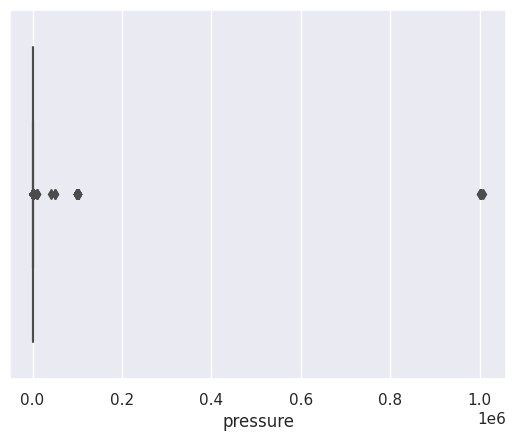

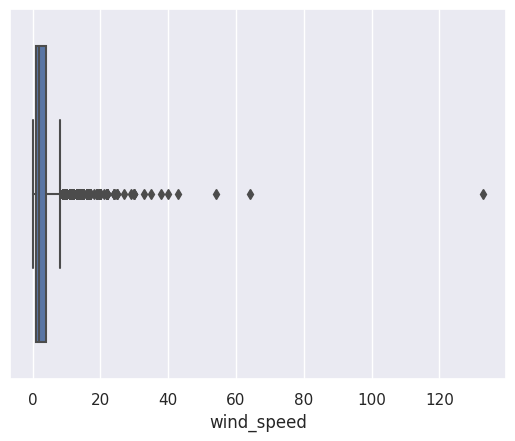

In [133]:
sns.boxplot(x=df_weather['pressure'])
plt.show()
sns.boxplot(x=df_weather['wind_speed'])
plt.show()

Drop values which are above bounderies of extremes

- Highest pressure recorded is 1050 in 2015 (ref. https://www.levante-emv.com/opinion/2015/01/27/presion-record-lugares-espana-enero-12677646.html)
- Lowest pressure recorded is 950 hPa in 1941 (ref. https://documentacion.fundacionmapfre.org/documentacion/publico/i18n/media/group/1021716.do)

In [177]:
df_weather.loc[df_weather.pressure > 1051, 'pressure'] = np.nan
df_weather.loc[df_weather.pressure < 951, 'pressure'] = np.nan

In [178]:
df_weather.loc[df_weather.wind_speed > 50, 'wind_speed'] = np.nan

Fill null values using interpolation

In [179]:
df_weather.interpolate(method='linear', limit_direction='forward', inplace=True, axis=0)

## Merging datasets

In [180]:
dfs = [x for _, x in df_weather.groupby('city_name')]

In [181]:
dfs[0].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35060 entries, 2015-01-01 00:00:00 to 2018-12-31 23:00:00
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   city_name   35060 non-null  object 
 1   temp        35060 non-null  float64
 2   temp_min    35060 non-null  float64
 3   temp_max    35060 non-null  float64
 4   pressure    35060 non-null  float64
 5   humidity    35060 non-null  float64
 6   wind_speed  35060 non-null  float64
 7   wind_deg    35060 non-null  float64
 8   rain_1h     35060 non-null  float64
 9   rain_3h     35060 non-null  float64
 10  snow_3h     35060 non-null  float64
 11  clouds_all  35060 non-null  float64
dtypes: float64(11), object(1)
memory usage: 3.5+ MB


Merge city weather data to energy use dataset:

In [182]:
df_final = df_energy

for city, df in zip(cities, dfs):
    df = df.add_suffix(f'_{city}')
    df_final = df_final.merge(df, on=['time'], how='outer')
    df_final = df_final.drop(f'city_name_{city}', axis=1)

df_final.columns

Index(['index', 'generation biomass', 'generation fossil brown coal/lignite',
       'generation fossil gas', 'generation fossil hard coal',
       'generation fossil oil', 'generation hydro pumped storage consumption',
       'generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation nuclear',
       'generation other', 'generation other renewable', 'generation solar',
       'generation waste', 'generation wind onshore', 'total load actual',
       'price day ahead', 'price actual', 'temp_Barcelona',
       'temp_min_Barcelona', 'temp_max_Barcelona', 'pressure_Barcelona',
       'humidity_Barcelona', 'wind_speed_Barcelona', 'wind_deg_Barcelona',
       'rain_1h_Barcelona', 'rain_3h_Barcelona', 'snow_3h_Barcelona',
       'clouds_all_Barcelona', 'temp_Bilbao', 'temp_min_Bilbao',
       'temp_max_Bilbao', 'pressure_Bilbao', 'humidity_Bilbao',
       'wind_speed_Bilbao', 'wind_deg_Bilbao', 'rain_1h_Bilbao',
       'rain_3h_Bilbao', 'snow_3h_Bilb

In [183]:
cities[3] = 'Barcelona'

In [184]:
df_final.isnull().values.sum()

0

In [185]:
 df_final.duplicated(keep='first').sum()

0

Split date so it's easier to work with

In [186]:
for i in range(len(df_final)):
    position = df_final.index[i]
    df_final.loc[position, 'date'] = f'{position.year}-{position.month}-{position.day}'
    df_final.loc[position, 'hour'] = position.hour
    df_final.loc[position, 'day'] = position.day
    df_final.loc[position, 'month'] = position.month
    df_final.loc[position, 'year'] = position.year

In [187]:
new_df = df_final.groupby(['year', 'month', 'day']).mean()

<ipython-input-187-b367889832f3>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  new_df = df_final.groupby(['year', 'month', 'day']).mean()


In [188]:
df_final = df_final.drop(['hour'], axis=1)

In [189]:
# new_df['date'] = pd.to_datetime(df_final['date'], utc=True)
new_df = new_df.reset_index().set_index(df_final['date'].unique()).drop(['hour'], axis=1)

In [218]:
df_final = df_final.drop(['date'], axis=1)

In [190]:
new_df

,year,month,day,index,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,...,temp_min_Valencia,temp_max_Valencia,pressure_Valencia,humidity_Valencia,wind_speed_Valencia,wind_deg_Valencia,rain_1h_Valencia,rain_3h_Valencia,snow_3h_Valencia,clouds_all_Valencia
2015-1-1,2015.0,1.0,1.0,11.5,428.500000,257.416667,4256.750000,4246.541667,160.208333,1070.416667,...,275.955570,275.955570,1010.000000,69.750000,1.000000,216.416667,0.0000,0.0,0.0,0.000000
2015-1-2,2015.0,1.0,2.0,35.5,385.291667,0.000000,3540.666667,1237.000000,198.625000,1543.666667,...,276.738833,276.738833,1013.833333,67.875000,1.125000,262.291667,0.0000,0.0,0.0,0.000000
2015-1-3,2015.0,1.0,3.0,59.5,440.500000,0.000000,3444.291667,1344.250000,226.583333,1338.458333,...,279.044010,279.044010,1007.375000,70.000000,1.791667,267.250000,0.0000,0.0,0.0,2.500000
2015-1-4,2015.0,1.0,4.0,83.5,397.125000,0.000000,3469.583333,2244.958333,355.416667,590.000000,...,279.366667,279.366667,1003.541667,74.916667,1.375000,220.083333,0.0000,0.0,0.0,0.000000
2015-1-5,2015.0,1.0,5.0,107.5,363.229167,17.916667,4439.812500,2557.229167,324.937500,1188.125000,...,278.740521,278.740521,1004.250000,80.833333,1.000000,234.625000,0.0000,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-27,2018.0,12.0,27.0,34955.5,304.333333,698.375000,9744.125000,2899.083333,297.541667,139.750000,...,283.274583,284.232917,1027.083333,81.291667,1.250000,167.458333,0.0000,0.0,0.0,43.958333
2018-12-28,2018.0,12.0,28.0,34979.5,316.458333,656.166667,8060.791667,2777.083333,274.000000,81.000000,...,283.233333,284.650000,1027.500000,81.916667,1.625000,189.583333,0.0125,0.0,0.0,69.958333
2018-12-29,2018.0,12.0,29.0,35003.5,289.625000,4.708333,4981.833333,1733.833333,255.166667,602.250000,...,281.441667,282.900000,1029.041667,81.958333,1.333333,215.416667,0.0000,0.0,0.0,18.125000
2018-12-30,2018.0,12.0,30.0,35027.5,275.375000,0.000000,5269.541667,1525.291667,223.833333,620.708333,...,280.650000,282.108333,1029.458333,73.416667,1.416667,220.750000,0.0000,0.0,0.0,5.833333


# EDA

Plots time-series which has either been loaded in a dataframe, series or column.

In [191]:
def plot_series(df=None, column=None, series=pd.Series([]),
                label=None, ylabel=None, title=None, start=0, end=None):
    sns.set()
    fig, ax = plt.subplots(figsize=(30, 12))
    ax.set_xlabel('Time', fontsize=16)
    if column:
        ax.plot(df[column][start:end], label=label)
        ax.set_ylabel(ylabel, fontsize=16)
    if series.any():
        ax.plot(series, label=label)
        ax.set_ylabel(ylabel, fontsize=16)
    if label:
        ax.legend(fontsize=16)
    if title:
        ax.set_title(title, fontsize=24)
    ax.grid(True)
    return ax

<ipython-input-191-240f1c9b742a>:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  def plot_series(df=None, column=None, series=pd.Series([]),


## General

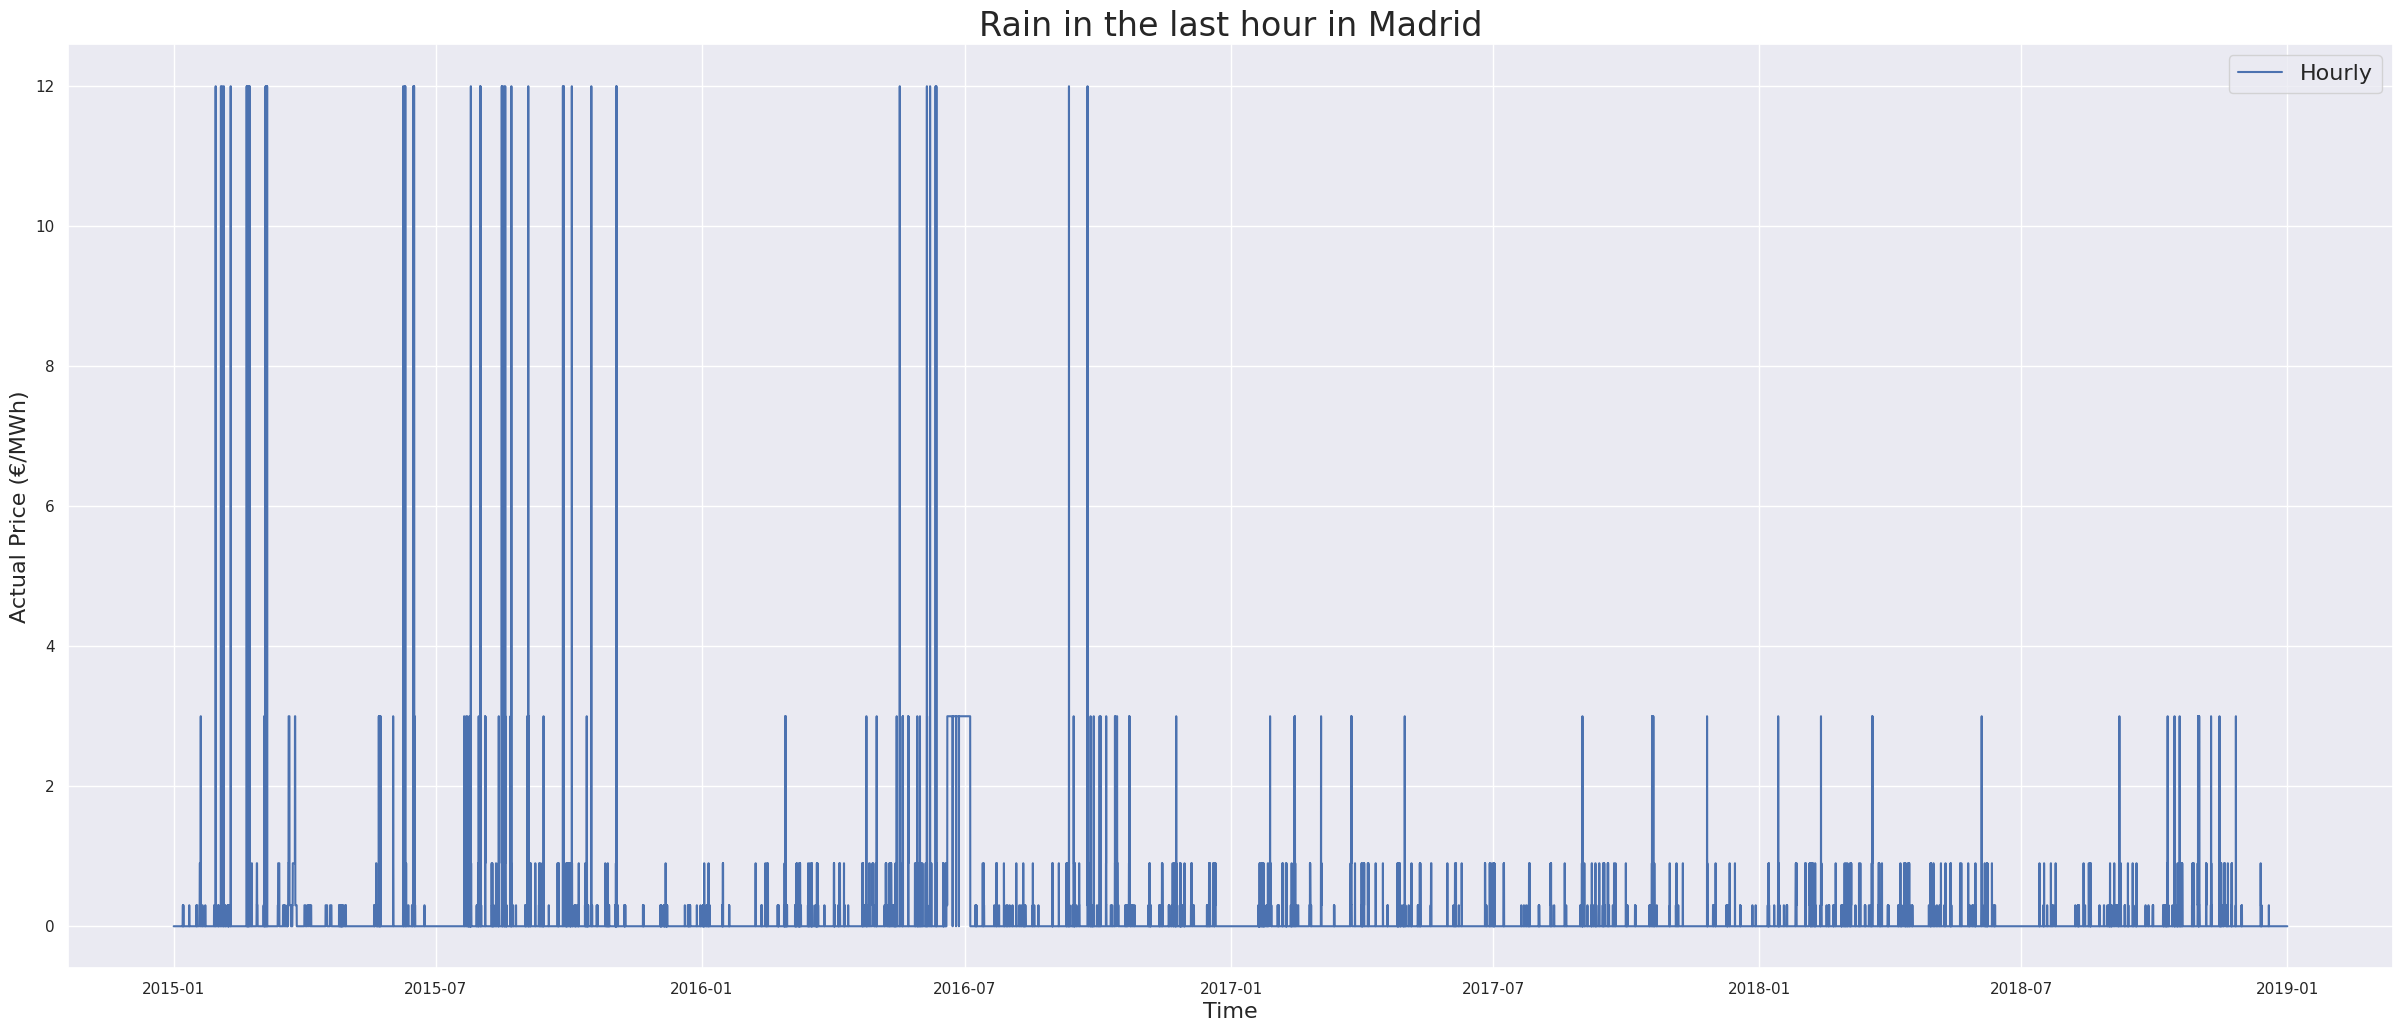

In [192]:
ax = plot_series(df_final, 'rain_1h_Barcelona',
                 label='Hourly', ylabel='Actual Price (€/MWh)',
                 title='Rain in the last hour in Madrid')
plt.show()

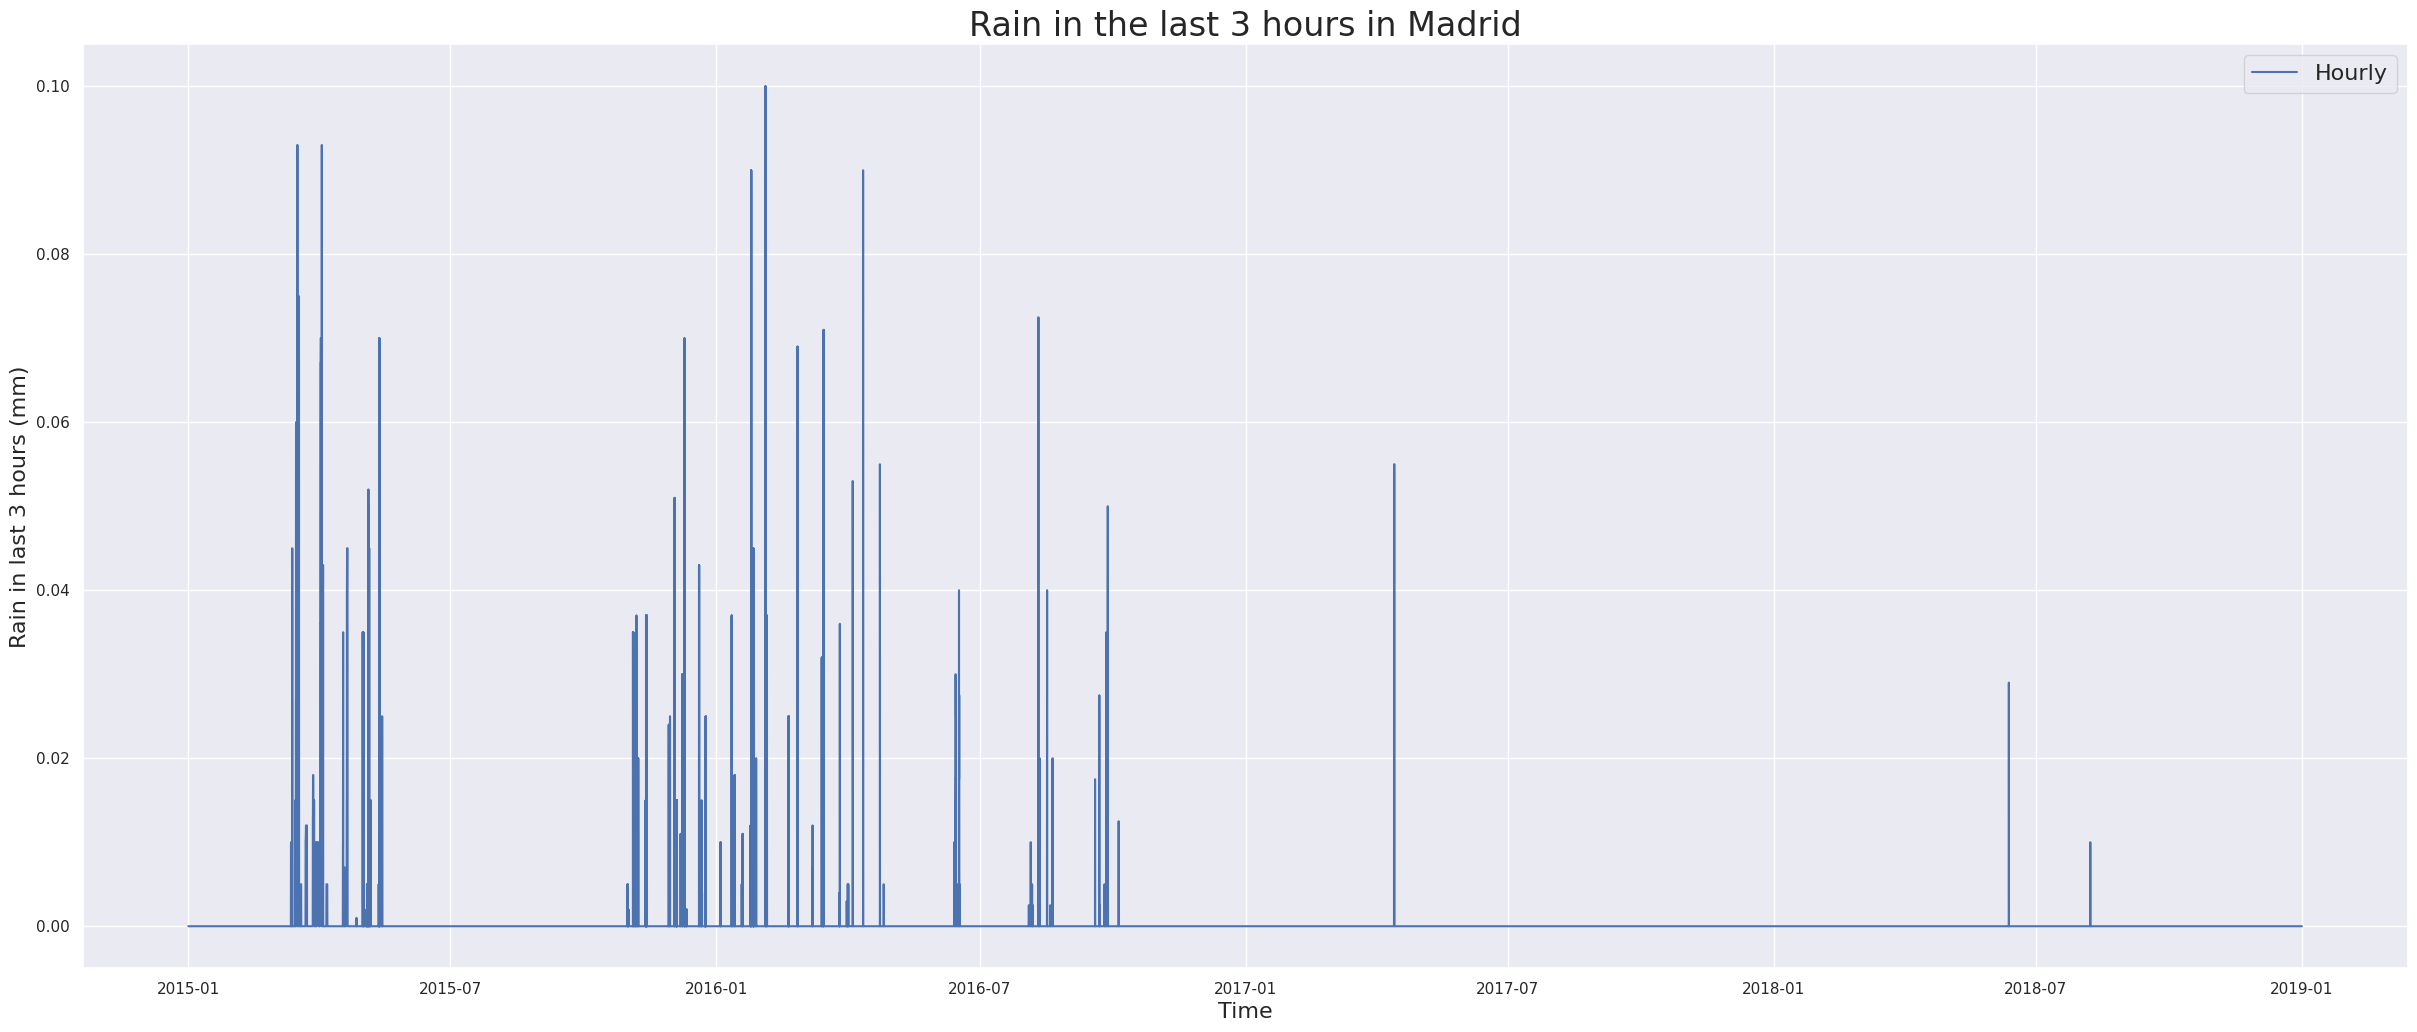

In [193]:
ax = plot_series(df_final, 'rain_3h_Barcelona',
                 label='Hourly', ylabel='Rain in last 3 hours (mm)',
                 title='Rain in the last 3 hours in Madrid')
plt.show()

We can conclude that 'rain_3h' is an unreliable feature so we will drop it.

In [194]:
for city in cities:
    df_final = df_final.drop([f'rain_3h_{city}'], axis=1)

Plot the hourly actual electricity price, along with the weekly rolling mean

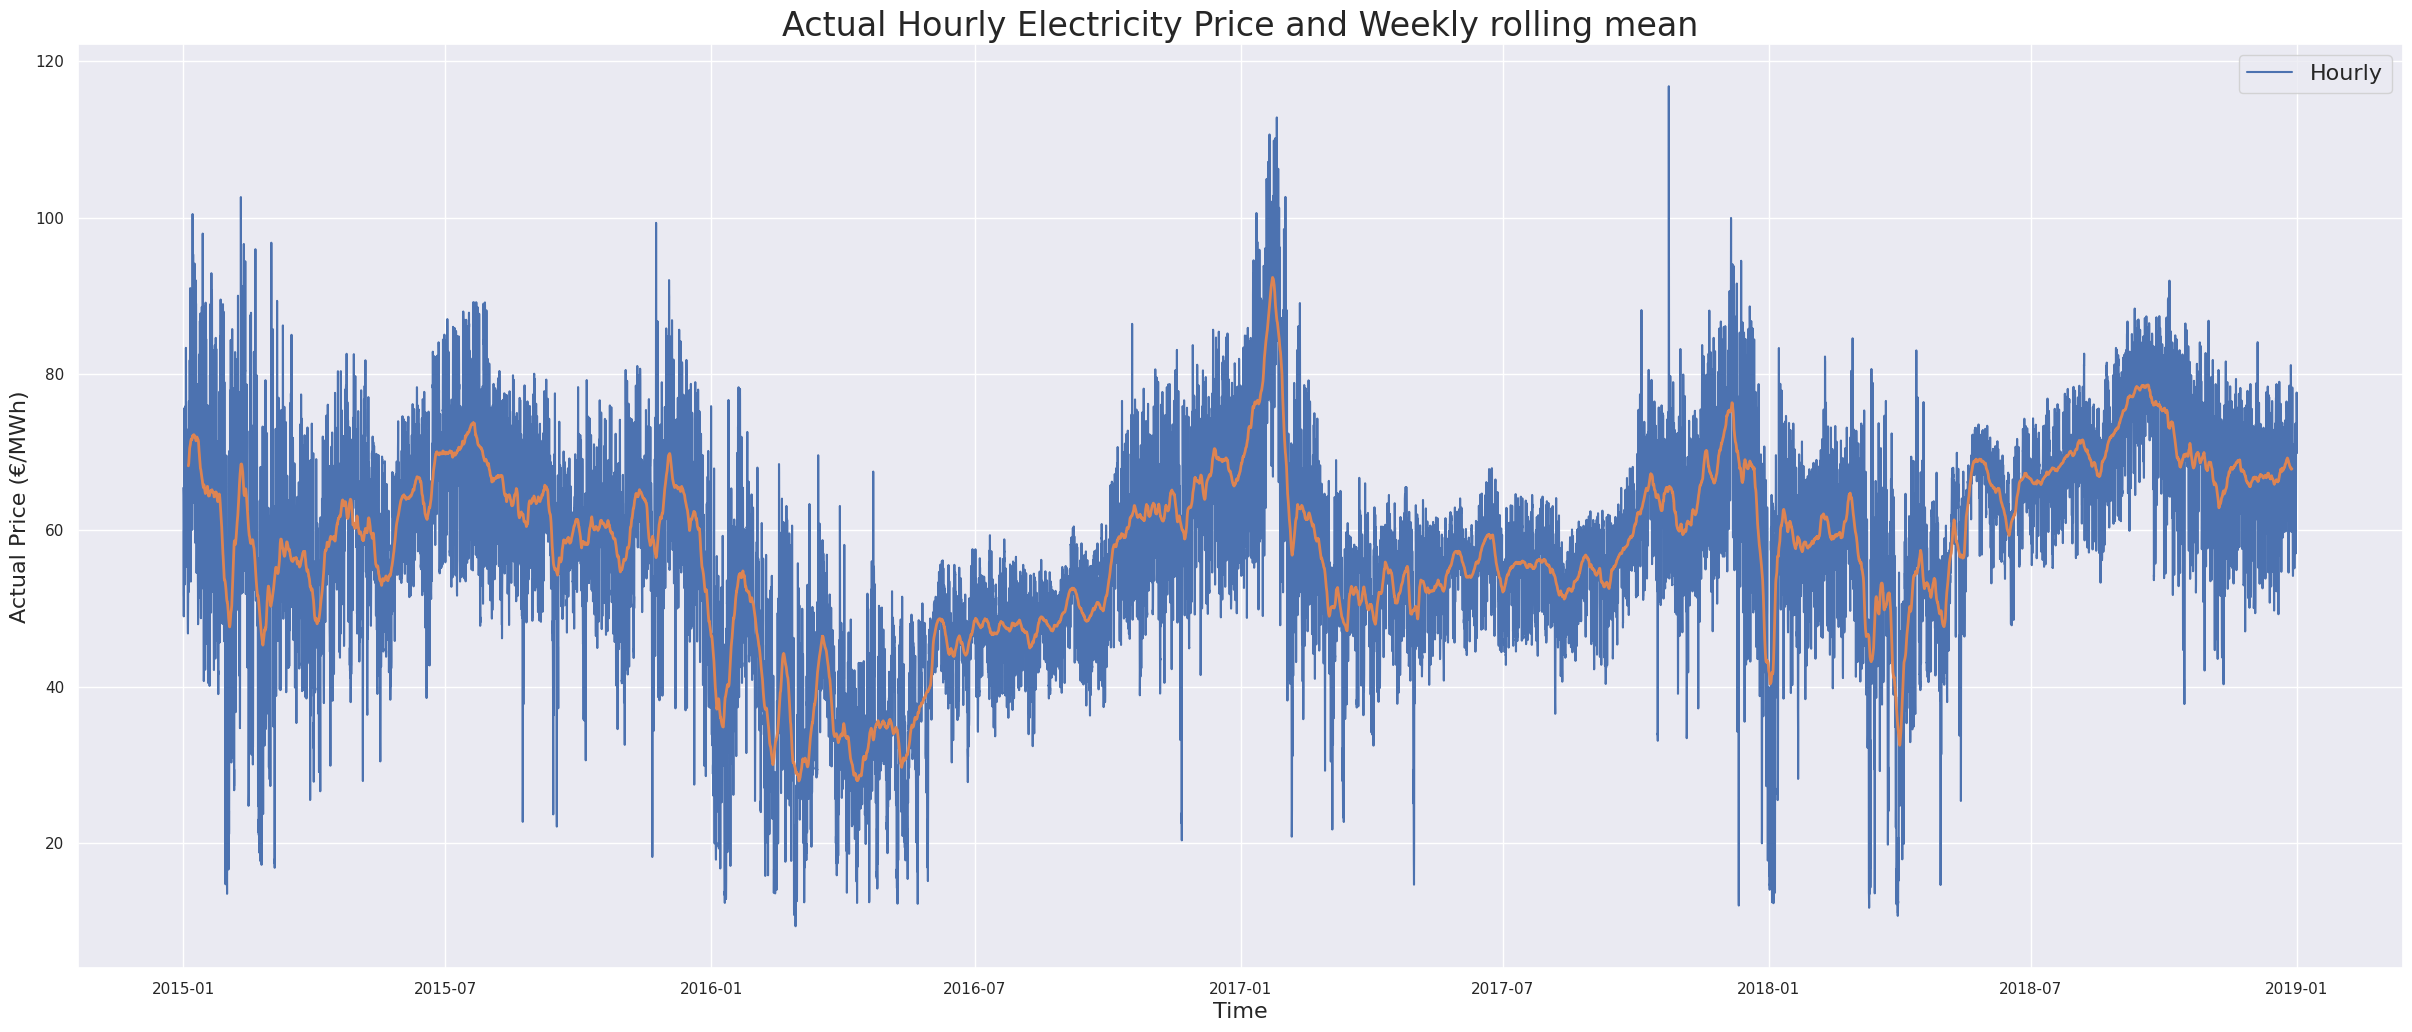

In [195]:
rolling = df_final['price actual'].rolling(24*7, center=True).mean()
ax = plot_series(df_final, 'price actual', label='Hourly', ylabel='Actual Price (€/MWh)',
                 title='Actual Hourly Electricity Price and Weekly rolling mean')
ax.plot(rolling, linestyle='-', linewidth=2, label='Weekly rolling mean')
plt.show()

Plot the electricity price (monthly frequence) along with its 1-year lagged series

In [153]:
df_final.columns

Index(['generation biomass', 'generation fossil brown coal/lignite',
       'generation fossil gas', 'generation fossil hard coal',
       'generation fossil oil', 'generation hydro pumped storage consumption',
       'generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation nuclear',
       'generation other', 'generation other renewable', 'generation solar',
       'generation waste', 'generation wind onshore', 'total load actual',
       'price day ahead', 'price actual', 'temp_Barcelona',
       'temp_min_Barcelona', 'temp_max_Barcelona', 'pressure_Barcelona',
       'humidity_Barcelona', 'wind_speed_Barcelona', 'wind_deg_Barcelona',
       'rain_1h_Barcelona', 'snow_3h_Barcelona', 'clouds_all_Barcelona',
       'temp_Bilbao', 'temp_min_Bilbao', 'temp_max_Bilbao', 'pressure_Bilbao',
       'humidity_Bilbao', 'wind_speed_Bilbao', 'wind_deg_Bilbao',
       'rain_1h_Bilbao', 'snow_3h_Bilbao', 'clouds_all_Bilbao', 'temp_Madrid',
       'temp_m

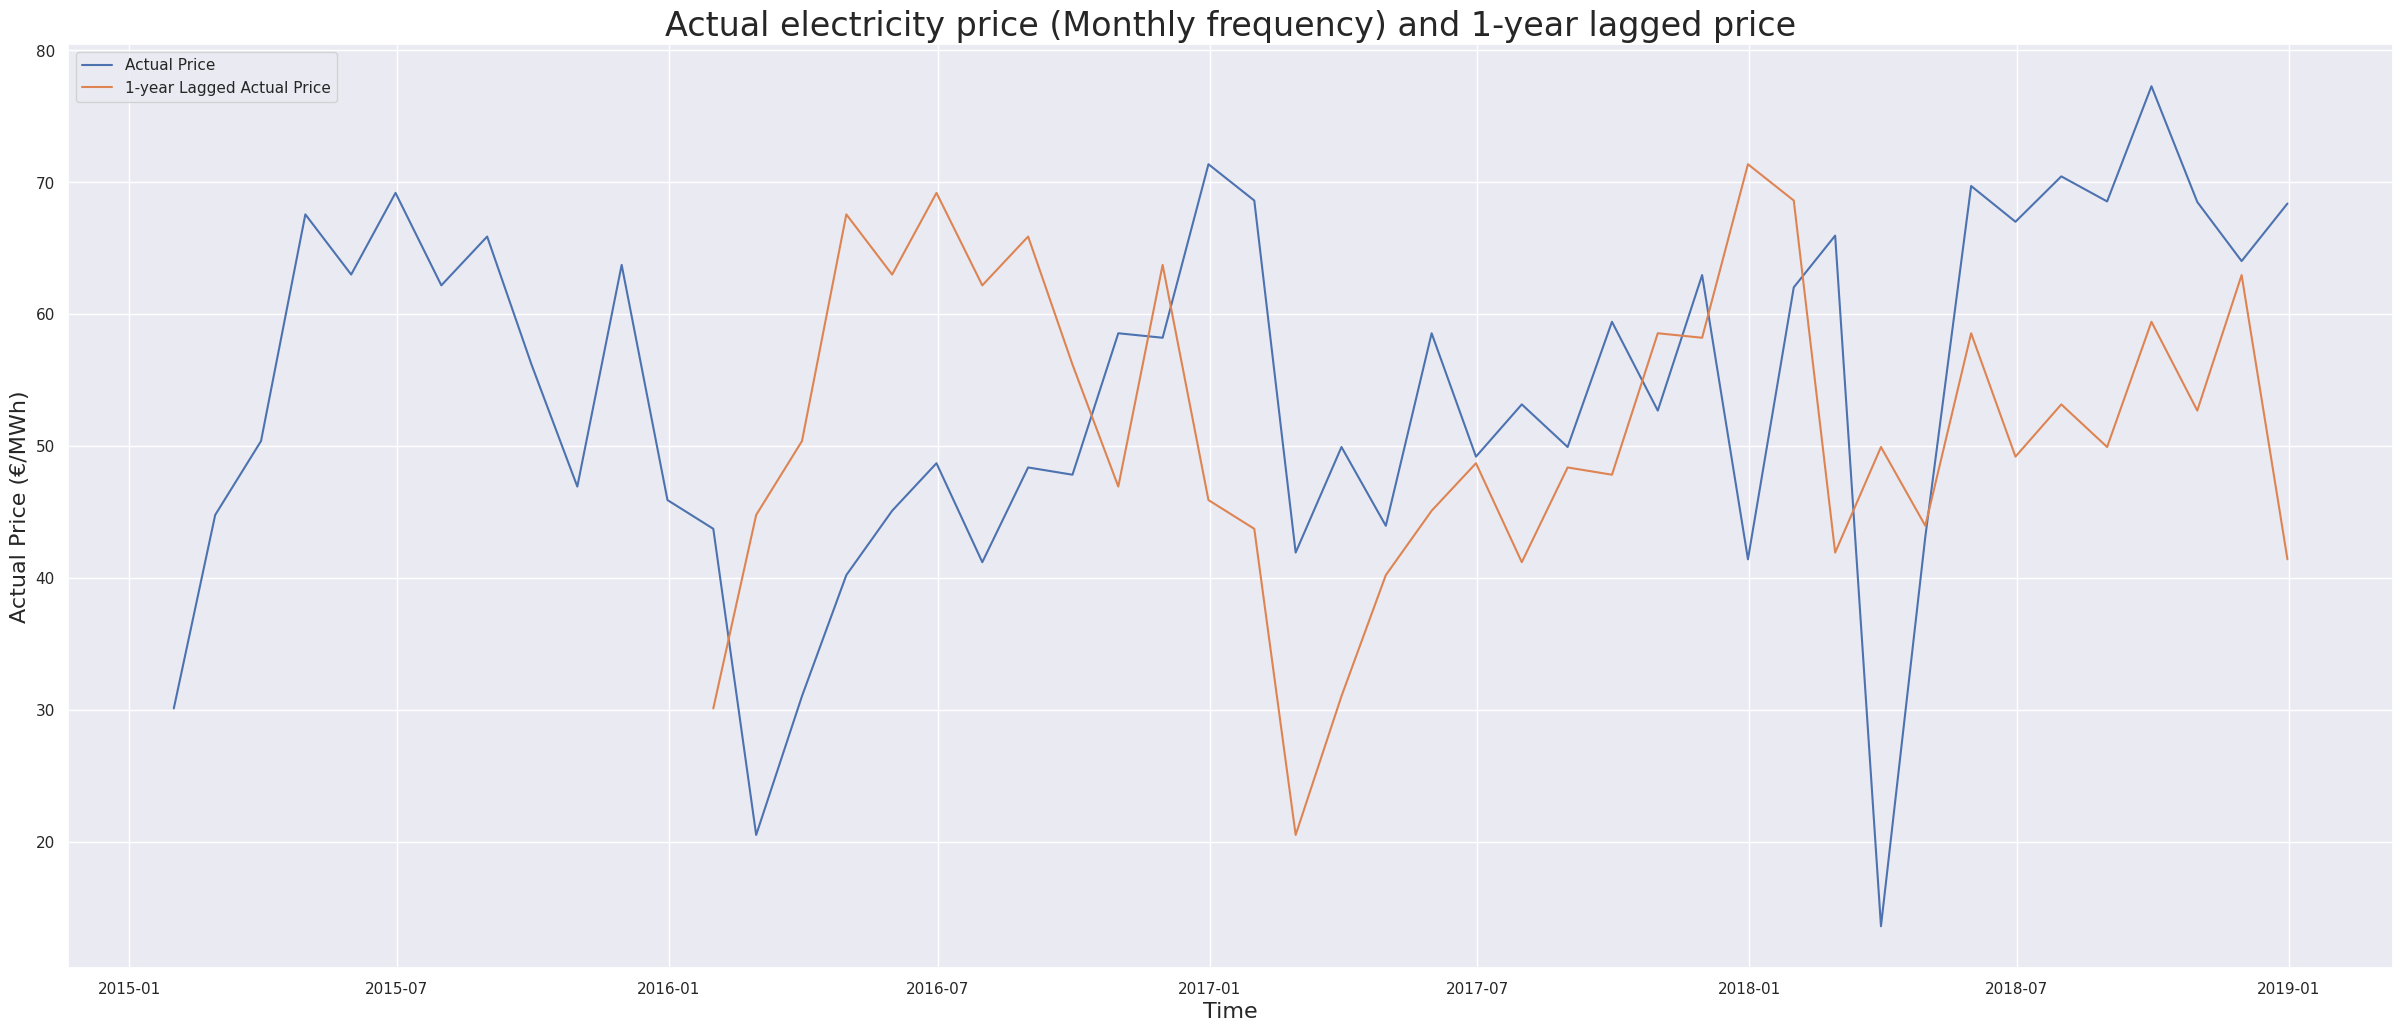

In [197]:
monthly_price = df_final['price actual'].asfreq('M')
ax = plot_series(series=monthly_price, ylabel='Actual Price (€/MWh)',
                 title='Actual electricity price (Monthly frequency) and 1-year lagged price')
shifted = df_final['price actual'].asfreq('M').shift(12)
ax.plot(shifted, label='Hourly')
ax.legend(['Actual Price', '1-year Lagged Actual Price'])
plt.show()

We can see the resampled monthly frequency of the actual electricity price overlapped with its 12-month shift. From this, it's clear that there are seasonal patterns at a monthly scale as there are spikes at exactly the same months. Hence, it would be sensible to create an additional feature with this data as we won't see such patterns at other scales like weekly.

Plot the actual electricity price at a daily/weekly scale

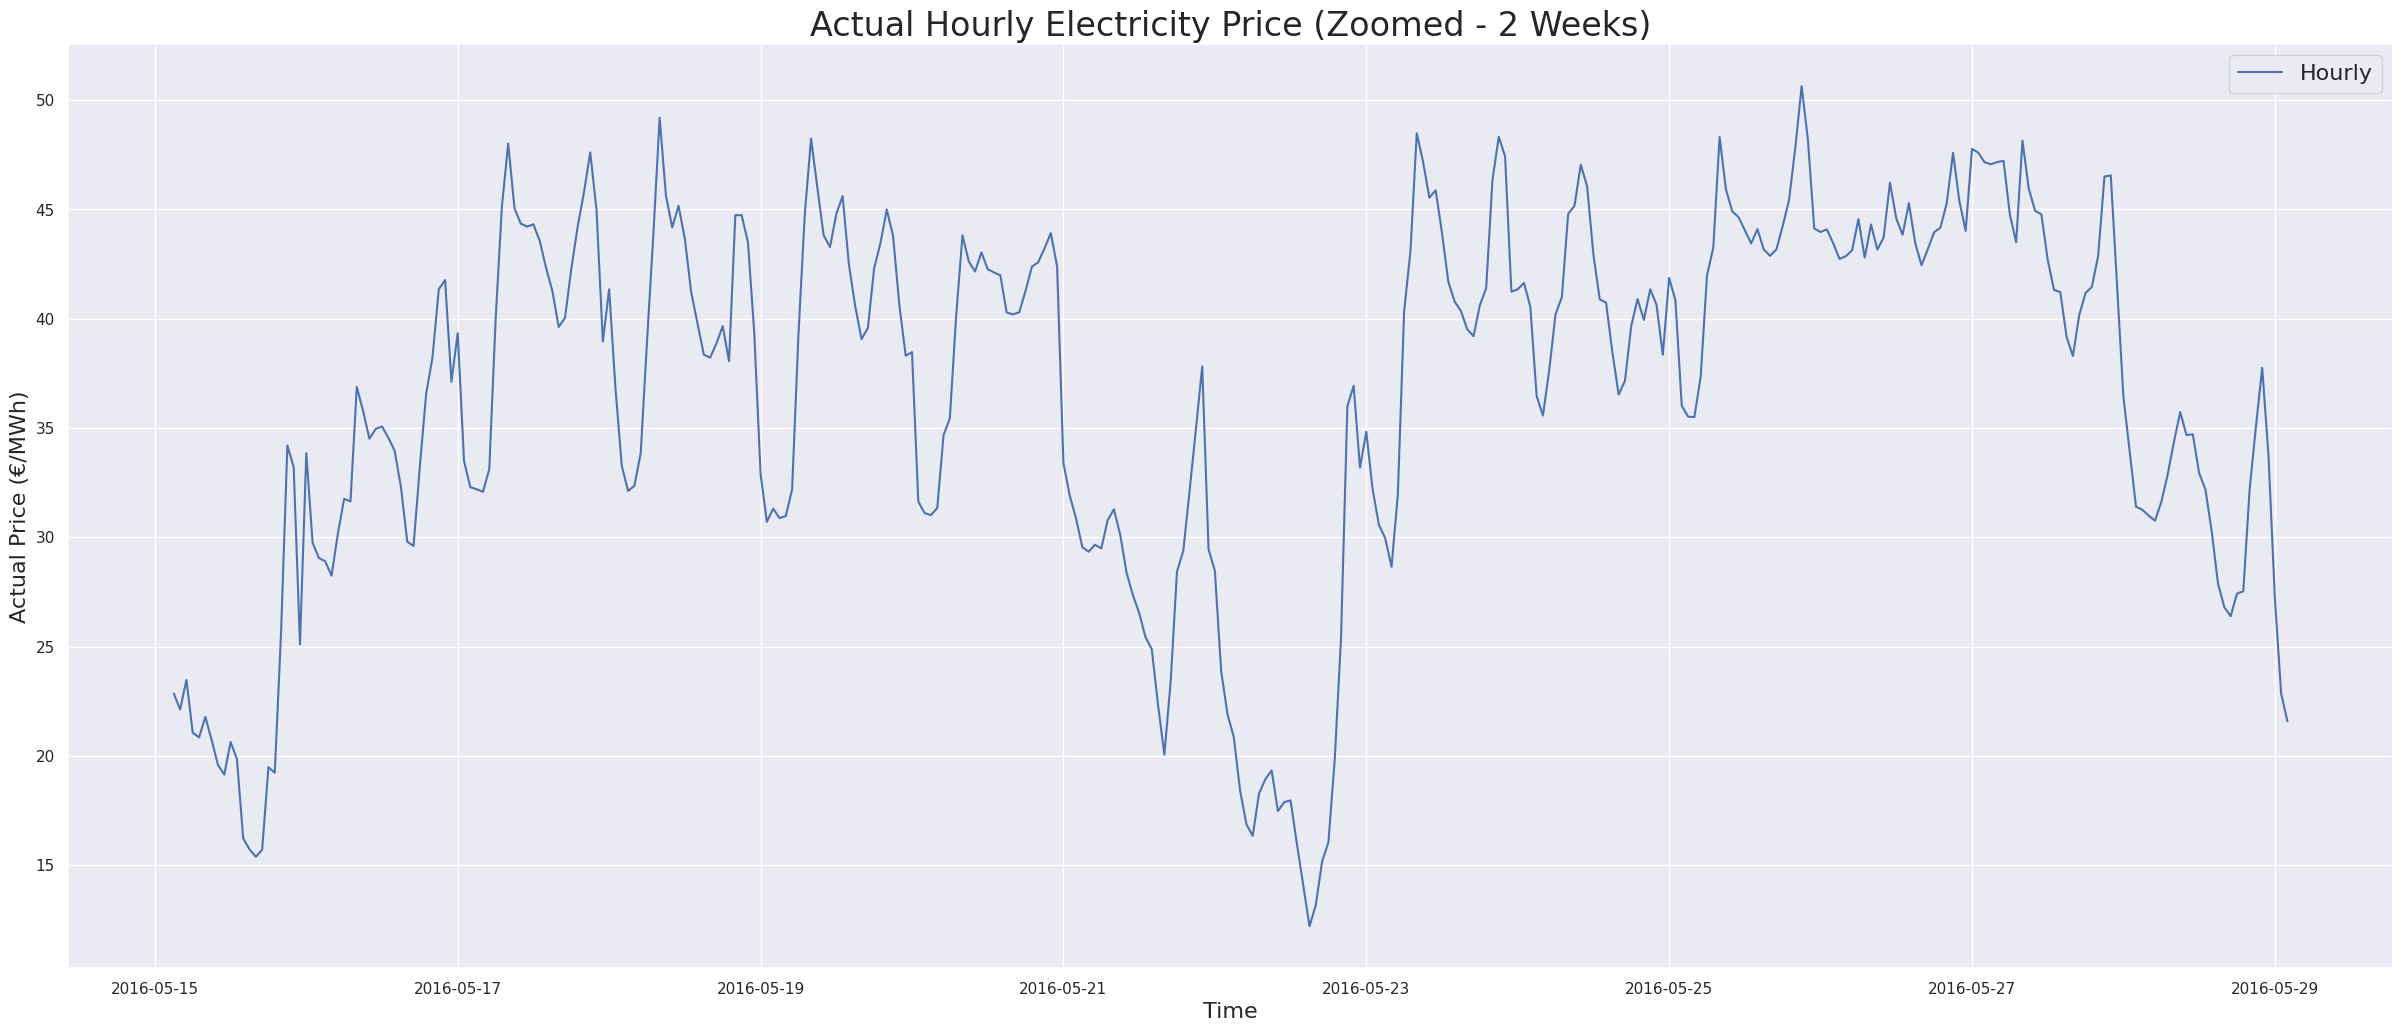

In [203]:
ax = plot_series(df_final, 'price actual', label='Hourly', ylabel='Actual Price (€/MWh)',
                 start=1 + 24 * 600, end=1 + 24 * 615,
                 title='Actual Hourly Electricity Price (Zoomed - 2 Weeks)')
plt.show()

We zoomed on the date of 2 weeks from **X** to **Y** where we can see hourly data and we can see the following patterns:

- A periodicity from week to week, as the electricity price tends to be higher during business days and lower during weekends and especially during sundays.
- An intraday periodicity, as the price is higher during the day and lower during the night.
- A periodicity within the business hours, as in some cases the electricity price drops for a few hours, which is probably due to siesta.

<Axes: ylabel='Frequency'>

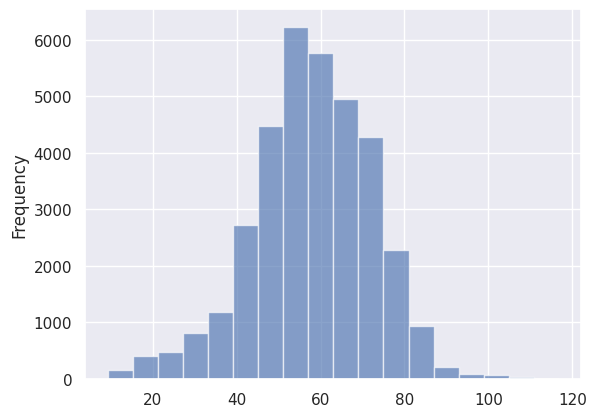

In [205]:
df_energy['price actual'].plot.hist(bins=18, alpha=0.65)

We obsorved that the actual energy price follows normal distribution allowing us to standardise it.

## Decomposition & Autocorrelation

Correlations between the electricity price and the rest of the features

In [206]:
print(df_final.corr(method='pearson')['price actual'].sort_values(ascending=False).to_string())

<ipython-input-206-b60f10c8c4c4>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  print(df_final.corr(method='pearson')['price actual'].sort_values(ascending=False).to_string())


price actual                                   1.000000
price day ahead                                0.732151
generation fossil hard coal                    0.465643
generation fossil gas                          0.461448
total load actual                              0.435283
generation fossil brown coal/lignite           0.364008
generation fossil oil                          0.285051
month                                          0.281225
generation other renewable                     0.255562
pressure_Barcelona                             0.249227
index                                          0.209163
pressure_Bilbao                                0.194105
generation waste                               0.168723
year                                           0.142841
generation biomass                             0.142696
temp_min_Valencia                              0.133137
pressure_Valencia                              0.109835
temp_min_Barcelona                             0

In [207]:
df_final = df_final.drop(['snow_3h_Barcelona', 'snow_3h_Seville'], axis=1)

<ipython-input-123-d2c86f9ce83b>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlations = df_final.corr(method='pearson')


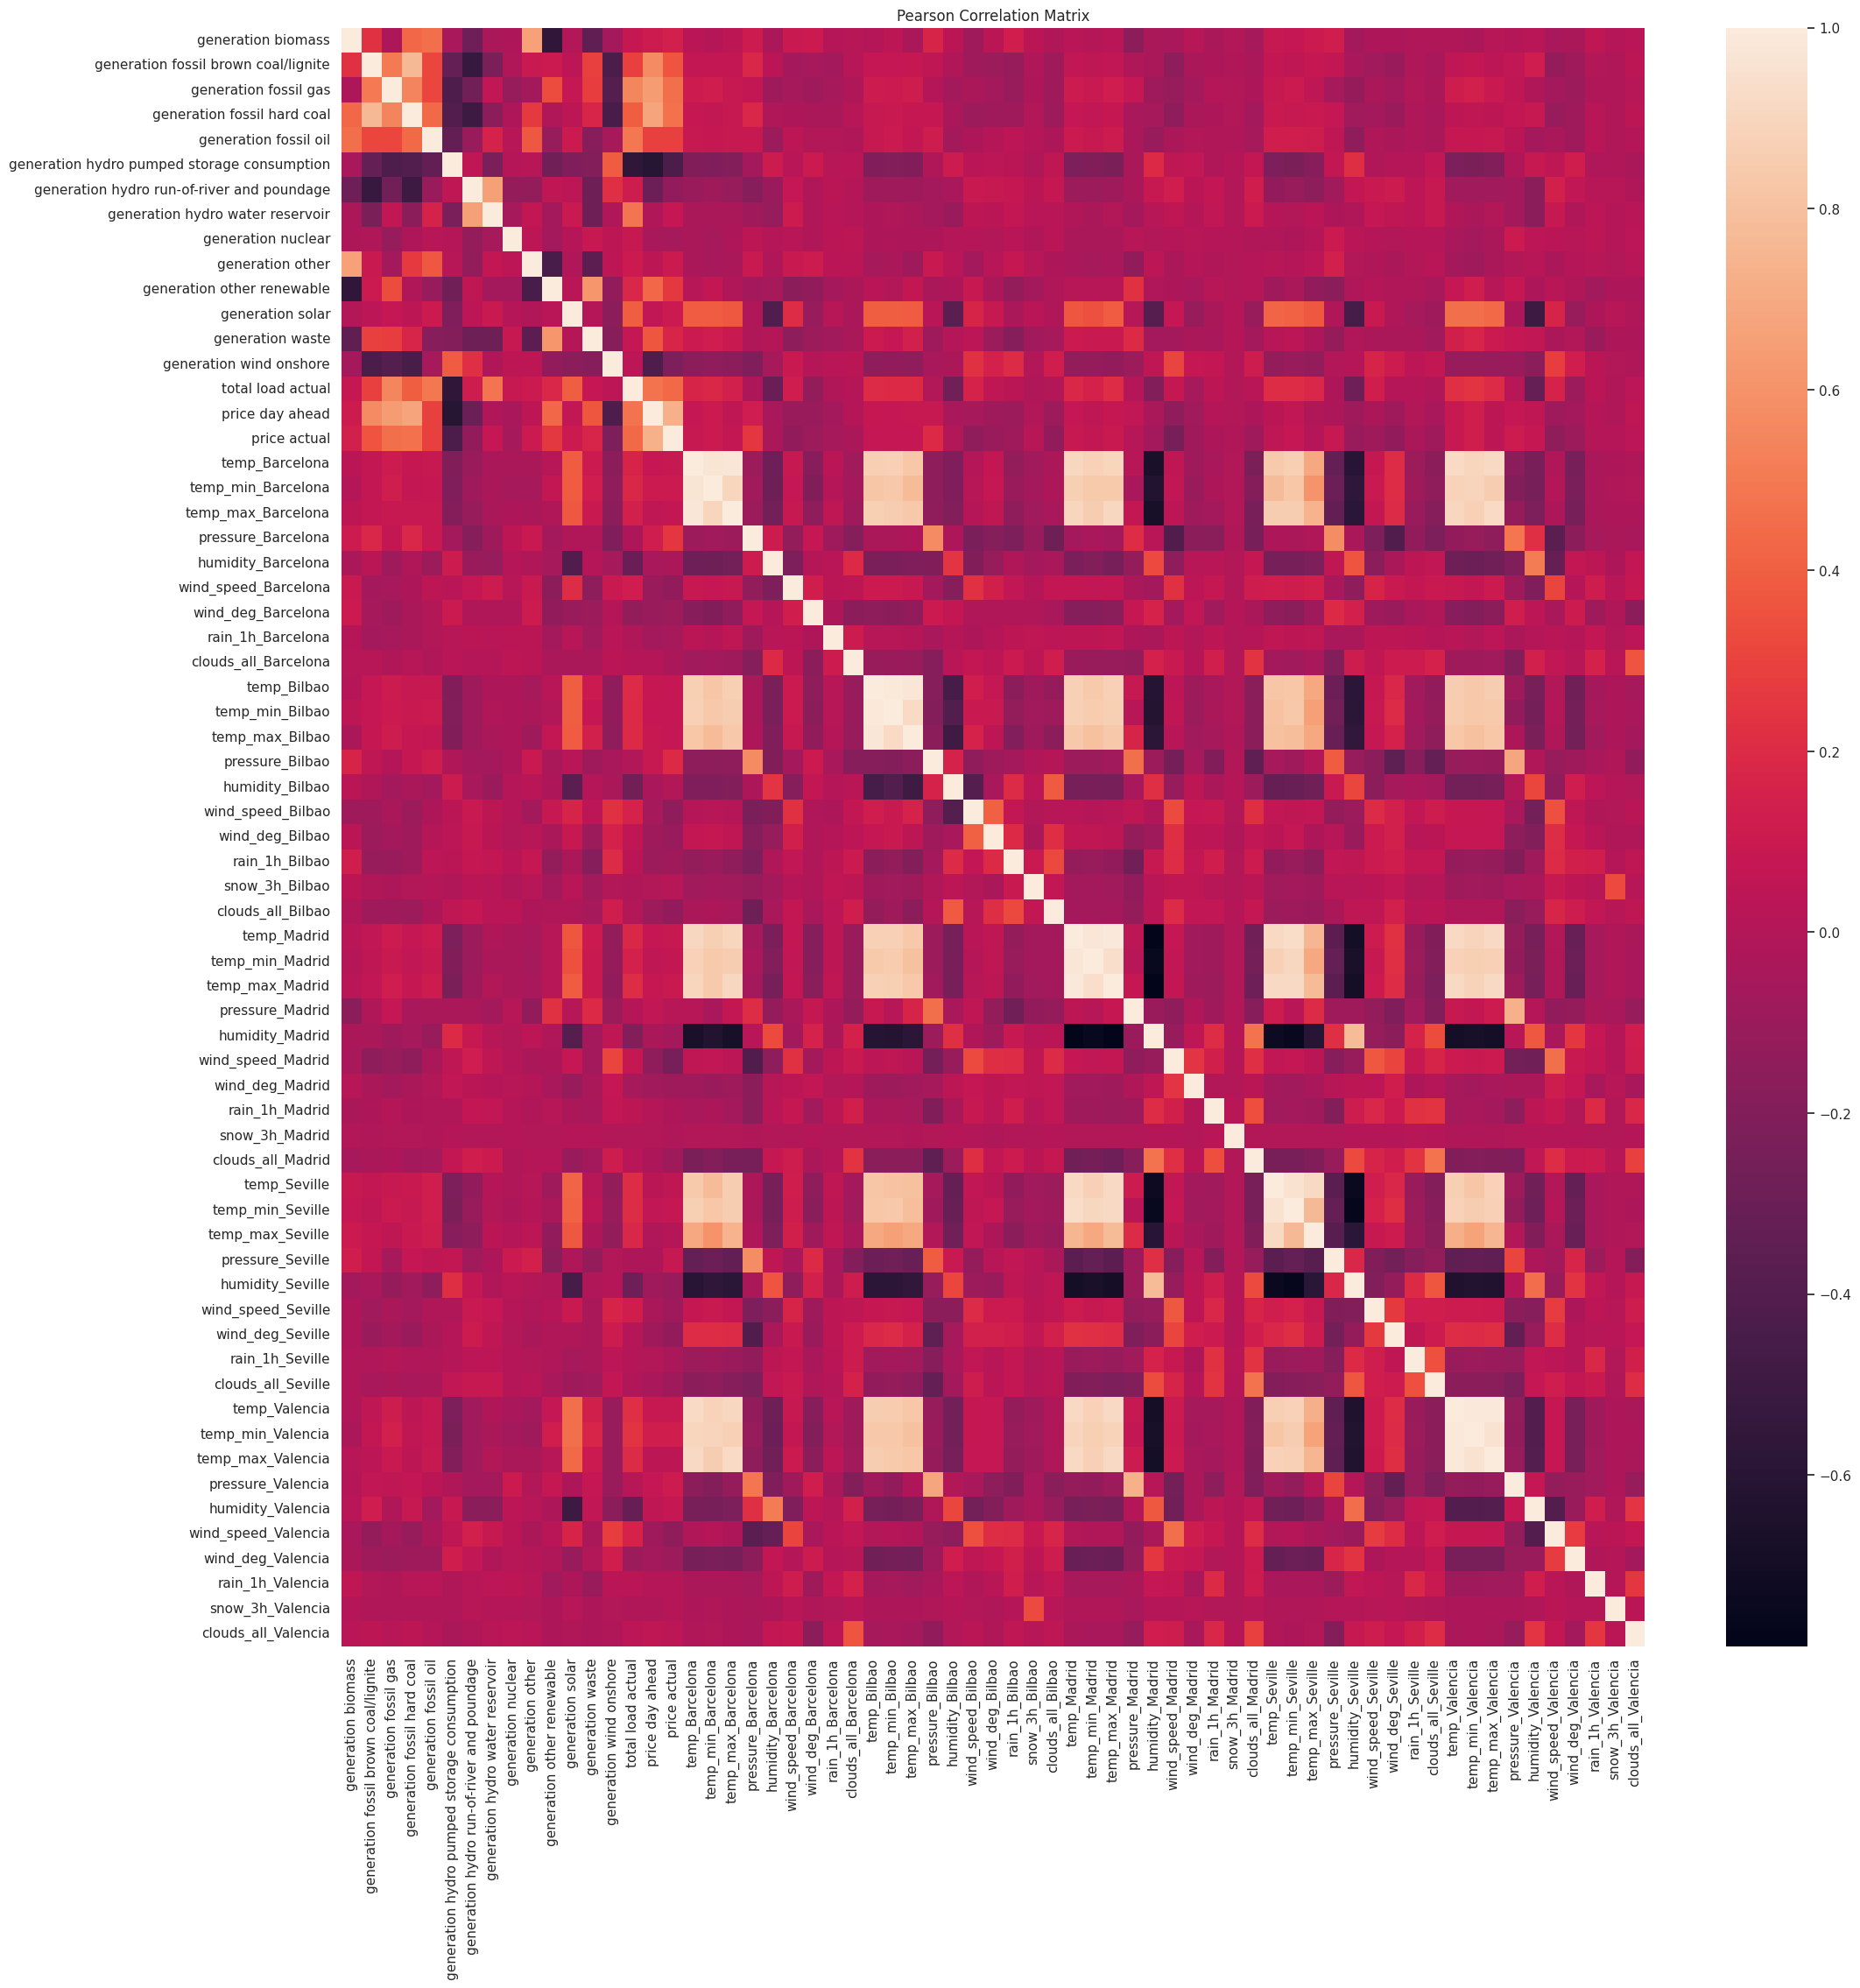

In [ ]:
correlations = df_final.corr(method='pearson')
fig = plt.figure(figsize=(24, 24))
sns.heatmap(correlations)
plt.title('Pearson Correlation Matrix')
plt.show()

In [208]:
df_final['generation coal all'] = df_final['generation fossil hard coal'] + df_final['generation fossil brown coal/lignite']

## Feature identification

The split data by hours of:
- the '**business** hour' will be equal to '2' if the given hour is within the business hours (Monday-Saturday, 9:30AM - 1:30PM and 4:30PM - 8PM);
- **siesta** equal to '1' (1:30PM - 4:30PM);
- the **rest** is '0' for all other hours.

In [209]:
for i in range(len(df_final)):
    position = df_final.index[i]
    hour = position.hour
    if ((hour > 8 and hour < 14) or (hour > 16 and hour < 21)):
        df_final.loc[position, 'business hour'] = 2
    elif (hour >= 14 and hour <= 16):
        df_final.loc[position, 'business hour'] = 1
    else:
        df_final.loc[position, 'business hour'] = 0

Potentially weighted by population absolute temprature range would benefit the data more

In [211]:
total_pop = 6155116 + 5179243 + 1645342 + 1305342 + 987000

cities_population = {
    'Madrid': 6155116,
    'Barcelona': 5179243,
    'Valencia': 1645342,
    'Seville': 1305342,
    'Bilbao': 987000
}

for i in range(len(df_final)):
    position = df_final.index[i]
    temp_weighted = 0
    for city in cities:
        temp_max = df_final.loc[position, f'temp_max_{city}']
        temp_min = df_final.loc[position, f'temp_min_{city}']
        temp_weighted += abs(temp_max - temp_min) * cities_population.get(city) / total_pop
    df_final.loc[position, 'temp_weighted'] = temp_weighted

Test/train split

In [212]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

In [213]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i + target_size])
        else:
            labels.append(target[i : i + target_size])

    return np.array(data), np.array(labels)

In [225]:
train_end_idx = 27048
cv_end_idx = 31056
test_end_idx = 35060

In [226]:
X = df_final[df_final.columns.drop('price actual')].values
y = df_final['price actual'].values

y = y.reshape(-1, 1)

In [227]:
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))
scaler_X.fit(X[:train_end_idx])
scaler_y.fit(y[:train_end_idx])
X_norm = scaler_X.transform(X)
y_norm = scaler_y.transform(y)

In [228]:
pca = PCA(n_components=0.80)
pca.fit(X_norm[:train_end_idx])
X_pca = pca.transform(X_norm)

dataset_norm = np.concatenate((X_pca, y_norm), axis=1)
future_target = 0

In [229]:
dataset_norm = np.concatenate((X_pca, y_norm), axis=1)

past_history = 24
future_target = 0

In [230]:
X_train, y_train = multivariate_data(dataset_norm, dataset_norm[:, -1],
                                     0, train_end_idx, past_history,
                                     future_target, step=1, single_step=True)
X_val, y_val = multivariate_data(dataset_norm, dataset_norm[:, -1],
                                 train_end_idx, cv_end_idx, past_history,
                                 future_target, step=1, single_step=True)
X_test, y_test = multivariate_data(dataset_norm, dataset_norm[:, -1],
                                   cv_end_idx, test_end_idx, past_history,
                                   future_target, step=1, single_step=True)

In [231]:
import tensorflow as tf

batch_size = 32
buffer_size = 1000

train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train = train.cache().shuffle(buffer_size).batch(batch_size).prefetch(1)

validation = tf.data.Dataset.from_tensor_slices((X_val, y_val))
validation = validation.batch(batch_size).prefetch(1)

In [232]:
y_test = y_test.reshape(-1, 1)
y_test_inv = scaler_y.inverse_transform(y_test)

# Model

## LSTM

In [233]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.losses import MeanSquaredError
from sklearn.metrics import mean_squared_error
from math import sqrt

In [237]:
def plot_model_rmse_and_loss(history):

    # Evaluate train and validation accuracies and losses

    train_rmse = history.history['root_mean_squared_error']
    val_rmse = history.history['val_root_mean_squared_error']

    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Visualize epochs vs. train and validation accuracies and losses

    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.plot(train_rmse, label='Training RMSE')
    plt.plot(val_rmse, label='Validation RMSE')
    plt.legend()
    plt.title('Epochs vs. Training and Validation RMSE')

    plt.subplot(1, 2, 2)
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend()
    plt.title('Epochs vs. Training and Validation Loss')

    plt.show()

In [234]:
optimizer = Adam(lr=6e-3, amsgrad=True)
loss = MeanSquaredError()
metric = [RootMeanSquaredError()]

input_shape = X_train.shape[-2:]
lr_schedule = LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch / 10))
early_stopping = EarlyStopping(patience=10)

In [235]:
lstm = Sequential([
    LSTM(100, input_shape=input_shape,
         return_sequences=True),
    Flatten(),
    Dense(200, activation='relu'),
    Dropout(0.1),
    Dense(1)
])

model_checkpoint = ModelCheckpoint('lstm.h5', monitor=('val_loss'), save_best_only=True)
lstm.compile(loss=loss, optimizer=optimizer, metrics=metric)

In [236]:
history = lstm.fit(train, epochs=120,
                                validation_data=validation,
                                callbacks=[early_stopping,
                                           model_checkpoint])

Epoch 1/120
845/845 [==============================] - 33s 36ms/step - loss: 0.0066 - root_mean_squared_error: 0.0813 - val_loss: 0.0063 - val_root_mean_squared_error: 0.0795


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/120
845/845 [==============================] - 32s 38ms/step - loss: 0.0027 - root_mean_squared_error: 0.0524 - val_loss: 0.0034 - val_root_mean_squared_error: 0.0584
Epoch 3/120
845/845 [==============================] - 28s 33ms/step - loss: 0.0021 - root_mean_squared_error: 0.0460 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0469
Epoch 4/120
845/845 [==============================] - 27s 32ms/step - loss: 0.0016 - root_mean_squared_error: 0.0399 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0427
Epoch 5/120
845/845 [==============================] - 27s 32ms/step - loss: 0.0014 - root_mean_squared_error: 0.0371 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0406
Epoch 6/120
845/845 [==============================] - 28s 33ms/step - loss: 0.0011 - root_mean_squared_error: 0.0336 - val_loss: 9.8692e-04 - val_root_mean_squared_error: 0.0314
Epoch 7/120
845/845 [==============================] - 29s 34ms/step - loss: 0.0010 - root_mean_squared_error: 0.0318 - v

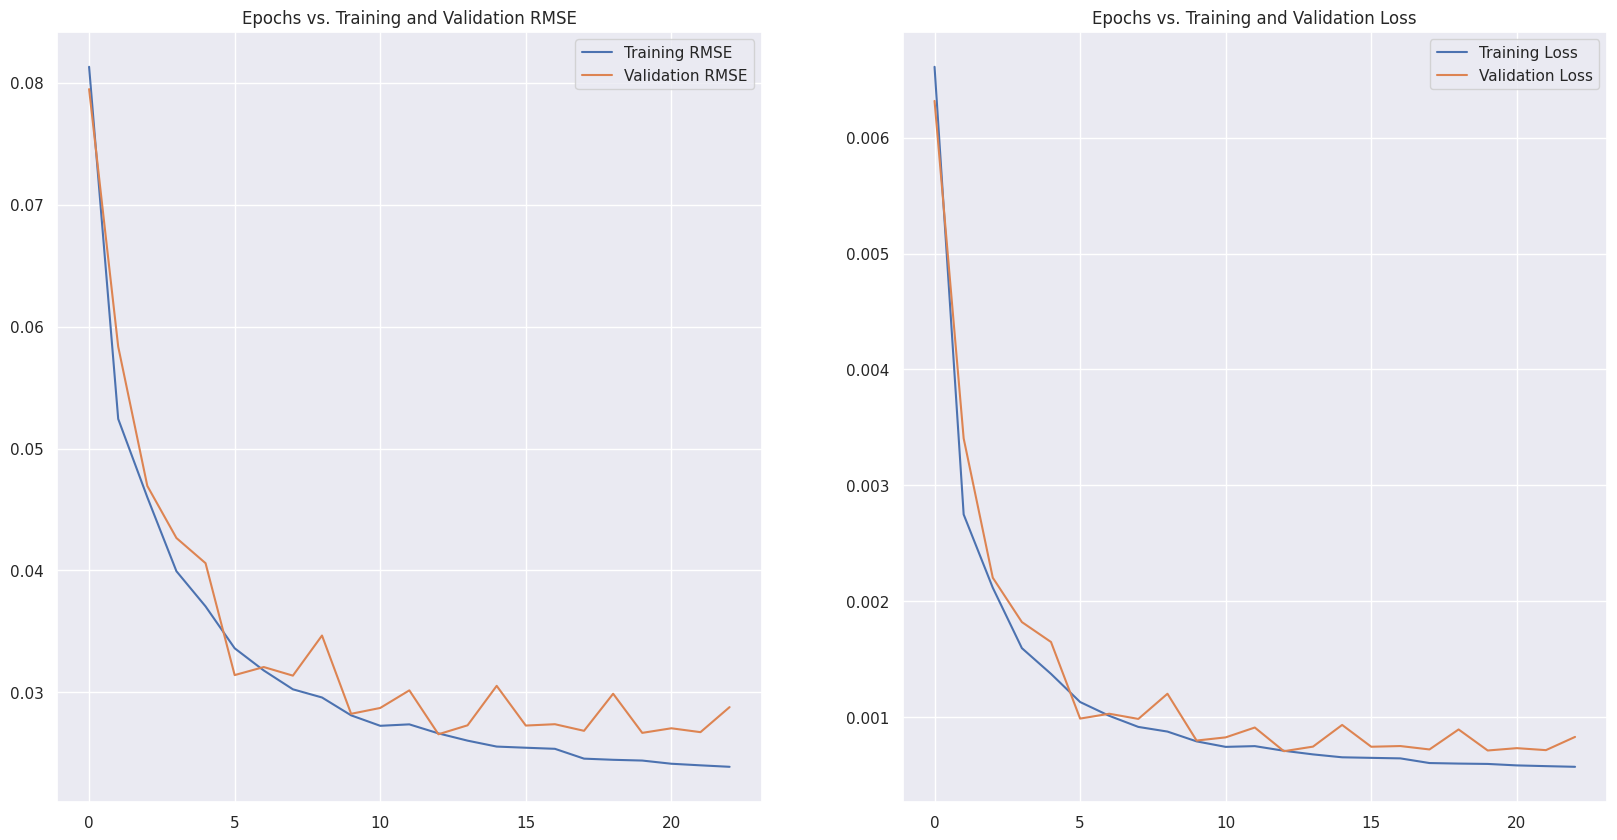

In [238]:
plot_model_rmse_and_loss(history)

In [239]:
lstm = tf.keras.models.load_model('lstm.h5')

forecast = lstm.predict(X_test)
lstm_forecast = scaler_y.inverse_transform(forecast)

rmse_lstm = sqrt(mean_squared_error(y_test_inv,
                                    lstm_forecast))
print(f'RMSE of hour-ahead electricity price LSTM forecast: {round(rmse_lstm, 3)}')

125/125 [==============================] - 2s 13ms/step
RMSE of hour-ahead electricity price LSTM forecast: 2.561


## ALT. LSTM

In [ ]:
lstm2 = Sequential([
    LSTM(100, activation='relu', return_sequences=True, input_shape=input_shape),
    LSTM(50, activation='relu'),
    Dropout(0.3),
    Dense(n_hours)
])

lstm2.compile(optimizer=optimizer, loss='mae')

## CNN LSTM

In [ ]:
multivariate_cnn = tf.keras.models.load_model('multivariate_cnn.h5')

forecast = multivariate_cnn.predict(X_test)
multivariate_cnn_forecast = scaler_y.inverse_transform(forecast)

rmse_mult_cnn = sqrt(mean_squared_error(y_test_inv,
                                        multivariate_cnn_forecast))
print(f'RMSE of hour-ahead price: {round(rmse_mult_cnn, 3)}')